# Overview

This notebook imports raw ws3 input data, reformats and monkey-patches the data, and exports Woodstock formatted input data files (which we will use in other DSS notebooks for this case as the input data files). 

# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import ws3.forest, ws3.core
import csv
import numpy as np
import time
from functools import partial, wraps
import distance
import operator

Define some key model parameters (will get used but defined here up top for convenience).

In [3]:
period_length = 10
max_age =  1000

In [4]:
# Input paths
vdyp_curves_smooth_tsa04_path = './data/vdyp_curves_smooth-tsa04.feather'



stands_shape_file_path = './data/redchris_largedata/redchris.shp'

# Output paths
stands_csv_path = './data/large_data/redchris_stands.csv'

stands__csv_path = './data/large_data/redchris_stands_.csv'

stands_mdf_csv_path = './data/large_data/redchris_stands_mdf.csv'

yld_vdyp_csv_path = './data/large_data/redchris_yld_vdyp.csv'

yldmerged_csv_path = './data/large_data/redchris_yldmerged.csv'

woodstock_model_files_lan_path = './data/woodstock_model_files/redchris.lan'
woodstock_model_files_are_path = './data/woodstock_model_files/redchris.are'
woodstock_model_files_yld_path = './data/woodstock_model_files/redchris.yld'
woodstock_model_files_act_path = './data/woodstock_model_files/redchris.act'
woodstock_model_files_trn_path = './data/woodstock_model_files/redchris.trn'

# Import and reformat inventory and yield input data

Read forest inventory data into memory (vector polygon GIS data layer with attribute table, in ESRI Shapefile format). This dataset represents timber supply area (TSA) 04 in British Columbia. We monkey-patch the inventory data here to make it line up nicely with what we need downstream as input for the ws3 model (i.e., changes we make here to the in-memory dataset are not saved to the original dataset on disk). Most of what we are doing here is setting up the _theme_ columns in the attribute table, which should help newer ws3 users make the connection between input data and the landscape themes in ws3 model further down.

In [5]:
Start = time.time()
stands = gpd.read_file('data/redchris_largedata/redchris.shp')
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")

It took 0.7 minutes to run this script.


In [6]:
stands

,TSA_NUMBER,FEATURE_AR,BCLCS_LV_4,BEC_ZONE_1,SITE_INDEX,SPEC_CD_1,SPEC_PCT_1,SPEC_CD_2,SPEC_PCT_2,SHAPE_Leng,SHAPE_Area,contclass,rollup,netdown,THLB_Area,Age_2024,Block_ID,geometry
0,04,0.0,RO,BAFA,0.0,None,0.0,None,0.0,588.627446,16696.615026,C,THLB,THLB,1.669662,2,3,"POLYGON ((807513.607 1349311.061, 807513.734 1..."
1,04,0.0,RO,BAFA,0.0,None,0.0,None,0.0,1301.046619,25982.526969,C,THLB,THLB,2.598253,2,4,"POLYGON ((807378.190 1348978.369, 807355.691 1..."
2,04,0.0,RO,BAFA,0.0,None,0.0,None,0.0,832.881357,26271.132922,C,THLB,THLB,2.627113,2,5,"POLYGON ((807699.315 1349210.576, 807694.489 1..."
3,04,0.0,RO,BAFA,0.0,None,0.0,None,0.0,374.908584,6290.789616,C,THLB,THLB,0.629079,2,6,"POLYGON ((807429.468 1349084.416, 807428.616 1..."
4,04,0.0,RO,BAFA,0.0,None,0.0,None,0.0,784.933594,28246.508136,C,THLB,THLB,2.824651,2,7,"POLYGON ((807977.819 1349033.951, 807960.505 1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103120,04,0.0,TM,BWBS,9.5,AT,45.0,SX,39.0,169.533923,1074.041760,N,6_Riparian,6_02_River_Buffer,0.000000,51,113989,"POLYGON ((782104.893 1432159.552, 782132.240 1..."
103121,04,0.0,SL,BAFA,11.4,AT,66.0,SX,16.0,336.436429,2005.001709,C,THLB,THLB,0.200500,128,117746,"POLYGON ((790171.987 1347475.215, 790162.690 1..."
103122,04,0.0,SL,BAFA,11.4,AT,66.0,SX,16.0,336.436429,2005.001709,N,3_Reserves,3_04_HabitatUWR_M-28,0.000000,128,117747,"POLYGON ((790171.987 1347475.215, 790162.690 1..."
103123,04,0.0,SL,BAFA,11.4,AT,66.0,SX,16.0,390.262529,2760.172644,C,THLB,THLB,0.276017,128,117748,"POLYGON ((790081.191 1347611.456, 790088.063 1..."


Import CANFI tree species lookup table (associates tree species names with integer numerical values, which we use as theme data values in the ws3 model), and insert species code values into the yield curve dataframe.

In [7]:
stands.to_csv(stands_csv_path, index=False)

In [44]:
canfi_map = {'AC':1211,
             'ACT':1201, # manually
             'AT':1201, 
             'BL':304,
             'B' :304, # manually
             'EP':1303, 
             'FDI':500, 
             'HW':402,
             'HM':403,
             'PL':204, 
             'PLI':204, 
             'SB':101, 
             'SE':104, 
             'SW':105, 
             'SX':100,
             'SXS':100, # manually
             'S':100,
            'AT+SX':1201,
            'SX+AT':100}

In [9]:
Aspen = ['AC', 'ACT', 'AT', 'EP', 'VB', 'MB', 'AT+SX']
Bal = ['B', 'BA', 'BG', 'BL']
Cedar = ['CW', 'YC']
Alder = ['D', 'DR']
DougFir = ['F', 'FD', 'FDC', 'FDI']
Hem = ['H', 'HM', 'HW']
Pine = ['PA', 'PL', 'PLC', 'PW', 'PLI', 'PY']
Spruce = ['S', 'SS', 'SW', 'SX', 'SE', 'SXW', 'SB', 'SX+AT']

Burn CANFI species codes into yield data tables.

In [10]:
def canfi_species(stratum_code):
    s = stratum_code.split('_')[-1].split('+')[0]
    result = canfi_map[s]
    return result

In [11]:
def stratify_stand(r, lexmatch=False, lexmatch_fieldname_suffix='_lexmatch'):
    result = ''
    if lexmatch:
        result += 3 * r['BEC_ZONE_CODE%s' % lexmatch_fieldname_suffix]
        result += '_'
        result += 2 * r['SPECIES_CD_1%s' % lexmatch_fieldname_suffix]
        if r.BCLCS_LV_4 == 'TM' and r.SPEC_CD_2 != None:
            result += '+' + r['SPECIES_CD_2%s' % lexmatch_fieldname_suffix]
    else:
        result += r.BEC_ZONE_1
        result += '_'
        result += r.SPEC_CD_1
        if r.BCLCS_LV_4 == 'TM' and r.SPEC_CD_2 != None:
            result += '+' + r.SPEC_CD_2
    return result

There are no species data for 16,137 stands, so we used the dominant species for each BEC zone to fill in the missing information.

                                                                            
| TSA_NUMBER | BEC_ZONE_C    | SPECIES_CD   |
|------------|---------------|--------------|
| 4          | BWBS          | PL           |
| 4          | SWB           | BL           |
| 4          | BAFA          | AT           |
| 4          | ESSF          | BL           |
| 4          | SBS           | BL           |
| 4          | ICH           | BL           |






In [12]:
print(stands[stands['SPEC_CD_1'].isna()])

       TSA_NUMBER  FEATURE_AR BCLCS_LV_4 BEC_ZONE_1  SITE_INDEX SPEC_CD_1  \
0              04         0.0         RO       BAFA         0.0      None   
1              04         0.0         RO       BAFA         0.0      None   
2              04         0.0         RO       BAFA         0.0      None   
3              04         0.0         RO       BAFA         0.0      None   
4              04         0.0         RO       BAFA         0.0      None   
...           ...         ...        ...        ...         ...       ...   
103082         04         0.0         TC       BWBS         0.0      None   
103083         04         0.0         TC       BWBS         0.0      None   
103087         04         0.0         TC       BWBS         0.0      None   
103088         04         0.0         TC       BWBS         0.0      None   
103115         04         0.0         TC       BWBS         0.0      None   

        SPEC_PCT_1 SPEC_CD_2  SPEC_PCT_2   SHAPE_Leng    SHAPE_Area contcla

In [13]:
species_mapping = {
('04',	'BWBS'): 	'PL',
('04',	'SWB'):	'BL',
('04',	'BAFA'):	'AT',
('04',	'ESSF'):	'BL',
('04',	'SBS'):	'BL',
('04',	'ICH'):	'BL'
}

In [14]:
def update_null_species_cd(row):
    if pd.isna(row['SPEC_CD_1']):
        key = (row['TSA_NUMBER'], row['BEC_ZONE_1'])
        # print(f"Row: {row}, Key: {key}")  # Debug statement
        return species_mapping.get(key, row['SPEC_CD_1'])
    return row['SPEC_CD_1']

In [15]:
stands['SPEC_CD_1'] = stands.apply(update_null_species_cd, axis=1)

In [16]:
print(stands[stands['SPEC_CD_1'].isna()])

Empty GeoDataFrame
Columns: [TSA_NUMBER, FEATURE_AR, BCLCS_LV_4, BEC_ZONE_1, SITE_INDEX, SPEC_CD_1, SPEC_PCT_1, SPEC_CD_2, SPEC_PCT_2, SHAPE_Leng, SHAPE_Area, contclass, rollup, netdown, THLB_Area, Age_2024, Block_ID, geometry]
Index: []


In [17]:
stands['BEC_ZONE_CODE_lexmatch'] = stands.BEC_ZONE_1.str.ljust(4, fillchar='x')

stands['SPECIES_CD_1_lexmatch'] = stands['SPEC_CD_1'].str.ljust(4, 'x')
stands['SPECIES_CD_1_lexmatch'] = stands['SPEC_CD_1'].str[:1] + stands['SPEC_CD_1']

stands['SPECIES_CD_2_lexmatch'] = stands['SPEC_CD_2'].str.ljust(4, 'x')
stands['SPECIES_CD_2_lexmatch'] = stands['SPEC_CD_2'].str[:1] + stands['SPEC_CD_2']

stratify_stand = stratify_stand
stratify_stand_lexmatch = partial(stratify_stand, lexmatch=True)

stands['stratum'] = stands.apply(stratify_stand, axis=1)
stands['stratum_lexmatch'] = stands.apply(stratify_stand_lexmatch, axis=1)

In [18]:
stands

,TSA_NUMBER,FEATURE_AR,BCLCS_LV_4,BEC_ZONE_1,SITE_INDEX,SPEC_CD_1,SPEC_PCT_1,SPEC_CD_2,SPEC_PCT_2,SHAPE_Leng,...,netdown,THLB_Area,Age_2024,Block_ID,geometry,BEC_ZONE_CODE_lexmatch,SPECIES_CD_1_lexmatch,SPECIES_CD_2_lexmatch,stratum,stratum_lexmatch
0,04,0.0,RO,BAFA,0.0,AT,0.0,None,0.0,588.627446,...,THLB,1.669662,2,3,"POLYGON ((807513.607 1349311.061, 807513.734 1...",BAFA,AAT,NaN,BAFA_AT,BAFABAFABAFA_AATAAT
1,04,0.0,RO,BAFA,0.0,AT,0.0,None,0.0,1301.046619,...,THLB,2.598253,2,4,"POLYGON ((807378.190 1348978.369, 807355.691 1...",BAFA,AAT,NaN,BAFA_AT,BAFABAFABAFA_AATAAT
2,04,0.0,RO,BAFA,0.0,AT,0.0,None,0.0,832.881357,...,THLB,2.627113,2,5,"POLYGON ((807699.315 1349210.576, 807694.489 1...",BAFA,AAT,NaN,BAFA_AT,BAFABAFABAFA_AATAAT
3,04,0.0,RO,BAFA,0.0,AT,0.0,None,0.0,374.908584,...,THLB,0.629079,2,6,"POLYGON ((807429.468 1349084.416, 807428.616 1...",BAFA,AAT,NaN,BAFA_AT,BAFABAFABAFA_AATAAT
4,04,0.0,RO,BAFA,0.0,AT,0.0,None,0.0,784.933594,...,THLB,2.824651,2,7,"POLYGON ((807977.819 1349033.951, 807960.505 1...",BAFA,AAT,NaN,BAFA_AT,BAFABAFABAFA_AATAAT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103120,04,0.0,TM,BWBS,9.5,AT,45.0,SX,39.0,169.533923,...,6_02_River_Buffer,0.000000,51,113989,"POLYGON ((782104.893 1432159.552, 782132.240 1...",BWBS,AAT,SSX,BWBS_AT+SX,BWBSBWBSBWBS_AATAAT+SSX
103121,04,0.0,SL,BAFA,11.4,AT,66.0,SX,16.0,336.436429,...,THLB,0.200500,128,117746,"POLYGON ((790171.987 1347475.215, 790162.690 1...",BAFA,AAT,SSX,BAFA_AT,BAFABAFABAFA_AATAAT
103122,04,0.0,SL,BAFA,11.4,AT,66.0,SX,16.0,336.436429,...,3_04_HabitatUWR_M-28,0.000000,128,117747,"POLYGON ((790171.987 1347475.215, 790162.690 1...",BAFA,AAT,SSX,BAFA_AT,BAFABAFABAFA_AATAAT
103123,04,0.0,SL,BAFA,11.4,AT,66.0,SX,16.0,390.262529,...,THLB,0.276017,128,117748,"POLYGON ((790081.191 1347611.456, 790088.063 1...",BAFA,AAT,SSX,BAFA_AT,BAFABAFABAFA_AATAAT


Read yield data from a CSV file and recast AU column data type to integer.

In [19]:
yld_vdyp = pd.read_feather(vdyp_curves_smooth_tsa04_path)
yld_vdyp['canfi_species'] = yld_vdyp.apply(lambda row: canfi_species(row['stratum_code']), axis=1).astype(int)
yld_vdyp['au_vdyp'] = pd.factorize(yld_vdyp['stratum_code'] + '_' + yld_vdyp['si_level'])[0] + 1

In [20]:
yld_vdyp

,index,age,volume,stratum_code,si_level,canfi_species,au_vdyp
0,17,18,6.282000e-11,ESSF_BL,L,304,1
1,18,19,3.625496e-08,ESSF_BL,L,304,1
2,19,20,7.916861e-07,ESSF_BL,L,304,1
3,20,21,6.105747e-06,ESSF_BL,L,304,1
4,21,22,2.801684e-05,ESSF_BL,L,304,1
...,...,...,...,...,...,...,...
12296,294,295,9.945361e+01,BWBS_AT,H,1201,42
12297,295,296,9.878314e+01,BWBS_AT,H,1201,42
12298,296,297,9.811513e+01,BWBS_AT,H,1201,42
12299,297,298,9.744960e+01,BWBS_AT,H,1201,42


Here we remove the rows related to stratums that are not in common with stands' stratum

In [21]:
# unique_values = yld_vdyp['stratum_code'].unique()

In [22]:
yld_vdyp = yld_vdyp[~yld_vdyp['stratum_code'].isin(['MH_HM', 'MH_BL', 'MH_SX'])]
yld_vdyp

,index,age,volume,stratum_code,si_level,canfi_species,au_vdyp
0,17,18,6.282000e-11,ESSF_BL,L,304,1
1,18,19,3.625496e-08,ESSF_BL,L,304,1
2,19,20,7.916861e-07,ESSF_BL,L,304,1
3,20,21,6.105747e-06,ESSF_BL,L,304,1
4,21,22,2.801684e-05,ESSF_BL,L,304,1
...,...,...,...,...,...,...,...
12296,294,295,9.945361e+01,BWBS_AT,H,1201,42
12297,295,296,9.878314e+01,BWBS_AT,H,1201,42
12298,296,297,9.811513e+01,BWBS_AT,H,1201,42
12299,297,298,9.744960e+01,BWBS_AT,H,1201,42


In [23]:
stratum_col = 'stratum'

In [24]:
yld_vdyp_ = yld_vdyp.reset_index().set_index('stratum_code')

In [25]:
stands_ = stands.reset_index().set_index(stratum_col)

In [26]:
Start = time.time()
names1 = set(stands_.loc[yld_vdyp_.index.values].stratum_lexmatch.unique())
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")

It took 20.2 minutes to run this script.


In [27]:
names1

{'BWBSBWBSBWBS_AATAAT',
 'BWBSBWBSBWBS_AATAAT+SSX',
 'BWBSBWBSBWBS_BBLBBL',
 'BWBSBWBSBWBS_PPLPPL',
 'BWBSBWBSBWBS_SSXSSX',
 'BWBSBWBSBWBS_SSXSSX+AAT',
 'ESSFESSFESSF_BBLBBL',
 'ESSFESSFESSF_PPLPPL',
 'ESSFESSFESSF_SSXSSX',
 'SBSxSBSxSBSx_AATAAT+SSX',
 'SBSxSBSxSBSx_BBLBBL'}

In [28]:
totalarea = stands_.FEATURE_AR.sum()
stands_['totalarea_p'] = stands_.FEATURE_AR / totalarea
names2 = set(stands_.stratum_lexmatch.unique()) - names1
stratum_key = stands_.reset_index().groupby('%s_lexmatch' % stratum_col)[stratum_col].first()
totalarea_p_sum__ = stands_.groupby('%s_lexmatch' % stratum_col).totalarea_p.sum()
lev_dist = {n2:{n1:distance.levenshtein(n1, n2) for n1 in names1} for n2 in names2} 
lev_dist_low = {n2:{n1:(lev_dist[n2][n1], totalarea_p_sum__.loc[n1]) 
                    for n1 in lev_dist[n2].keys() if lev_dist[n2][n1] == min(lev_dist[n2].values())} 
                for n2 in names2}
best_match = {stratum_key.loc[n2]:stratum_key[max(lev_dist_low[n2].items(), key=operator.itemgetter(1))[0]] for n2 in names2}
stands_.reset_index(inplace=True)

In [29]:
def match_stratum(r):
    return r[stratum_col] if r[stratum_col] in yld_vdyp_.index.values else best_match[r[stratum_col]]

stands_['%s_matched' % stratum_col] = stands_.apply(match_stratum, axis=1)

In [30]:
stands_ = stands_.copy()

In [31]:
stratum_col = '%s_matched' % stratum_col

In [32]:
stands__ = stands_.set_index(stratum_col)

Compile site index (SI) stats, including quantile levels.

In [33]:
stratum_si_stats = stands__.groupby(stratum_col).SITE_INDEX.describe(percentiles=[0, 0.05, 0.20, 0.35, 0.5, 0.65, 0.80, 0.95, 1])

In [34]:
# Function to find the closest column in stratum_si_stats and determine the level
def find_closest_column(row):
    si_levelquants = {'L': [0, 5, 20, 35], 'M': [35, 50, 65], 'H': [65, 80, 95, 100]}
    stratum_matched = row['stratum_matched']
    site_index = row['SITE_INDEX']   
    abs_diff = abs(site_index - stratum_si_stats.loc[stratum_matched, ['0%', '5%', '20%', '35%', '50%', '65%', '80%', '95%', '100%']])    
    closest_column = abs_diff.idxmin()    
    for level, quants in si_levelquants.items():
        if int(closest_column[:-1]) in quants:
            return level

stands_['si_level'] = stands_.apply(find_closest_column, axis=1)

In [35]:
au_vdyp_values = []
for index, row in stands_.iterrows():
    filtered_df = yld_vdyp[(yld_vdyp['stratum_code'] == row['stratum_matched']) & (yld_vdyp['si_level'] == row['si_level'])]    
    if not filtered_df.empty:
        # Get the value of au_vdyp from the first DataFrame and append it to the list
        au_vdyp_values.append(filtered_df['au_vdyp'].values[0])
    else:
        # If no matching rows found, append NaN
        au_vdyp_values.append(None)

# Add the new column 'au_vdyp' to the second DataFrame with the extracted values
stands_['au_vdyp'] = au_vdyp_values


In [41]:
stands_mdf['species'].map(canfi_map).unique()

array([1201.,   nan,  304.,  100.,  204.,  403., 1211.,  105.,  402.])

In [45]:
columns_to_keep = ['TSA_NUMBER', 'contclass', 'Age_2024', 'geometry', 'SPEC_CD_1', 'au_vdyp']
stands_mdf = stands_[columns_to_keep].copy()
stands_mdf.loc[:,'area'] = stands_mdf.geometry.area * 0.0001 # monkey-patch broken area attribute
stands_mdf =  stands_mdf.rename(columns={'TSA_NUMBER': 'theme0', 'contclass':'theme1', 'Age_2024':'age', 'SPEC_CD_1':'species', 'au_vdyp':'theme5'})
stands_mdf['theme0'] = stands_mdf['theme0'].replace({'04': 'tsa04'})
stands_mdf['theme1'] = stands_mdf['theme1'].replace({'C': 1, 'N': 0})
stands_mdf['theme2'] = stands_mdf['theme1']
stands_mdf = stands_mdf.drop(columns='geometry')
stands_mdf.insert(4, 'theme3',  stands_mdf['species'].map(canfi_map)) #Burn CANFI species codes into stand data
stands_mdf['theme3'] = stands_mdf['theme3'].astype(int)
stands_mdf.drop(columns=['species'], inplace=True)
stands_mdf.insert(5, 'theme4', stands_mdf['theme5']) # to be filled out with the scpecies code
stands_mdf.insert(6, 'age', stands_mdf.pop('age'))
stands_mdf

,theme0,theme1,theme3,theme5,theme4,area,age,theme2
0,tsa04,1,1201,40,40,1.669662,2,1
1,tsa04,1,1201,40,40,2.598253,2,1
2,tsa04,1,1201,40,40,2.627113,2,1
3,tsa04,1,1201,40,40,0.629079,2,1
4,tsa04,1,1201,40,40,2.824651,2,1
...,...,...,...,...,...,...,...,...
103120,tsa04,0,1201,19,19,0.107404,51,0
103121,tsa04,1,1201,42,42,0.200500,128,1
103122,tsa04,0,1201,42,42,0.200500,128,0
103123,tsa04,1,1201,42,42,0.276017,128,1


In [46]:
print('whole area (ha) is:', stands_mdf['area'].sum())
print('whole contributing area (ha) is:', stands_mdf[stands_mdf['theme1'] == 1]['area'].sum())
print('whole non-contributing area (ha) is:', stands_mdf[stands_mdf['theme1'] == 0]['area'].sum())

whole area (ha) is: 374791.3888999582
whole contributing area (ha) is: 330778.3765423137
whole non-contributing area (ha) is: 44013.01235764458


Create analysis unit (AU) dataframe from stands dataframe data.

In [47]:
AU = pd.DataFrame(stands_mdf['theme5']).drop_duplicates()
AU.rename(columns={'theme5':'au_vdyp'}, inplace=True)

Join `AU` and `yld_vdyp` dataframes.

In [48]:
yldmerged = pd.merge(AU, yld_vdyp, on=['au_vdyp'], how='inner')

In [49]:
au_yldmerged = yldmerged['au_vdyp'].drop_duplicates()

Add a new `curve_id` colume that has same data values as `AU` column.

In [50]:
yldmerged['curve_id'] = yldmerged['au_vdyp'] 

Save reformatted data to CSV files. 

In [51]:
stands_.to_csv(stands_csv_path, index=False)
stands_mdf.to_csv(stands_mdf_csv_path, index=False)
yld_vdyp.to_csv(yld_vdyp_csv_path, index=False)
yldmerged.to_csv(yldmerged_csv_path, header=True, index=False)
stands.to_csv(stands_csv_path, header=True, index=False)

Rename stuff to match variable names we expect further down.

In [52]:
stands_table = stands_mdf
curve_points_table = yldmerged
# curve_points_table = pd.read_csv("data/yldmerged_mmdf.csv")
curve_points_table.set_index('au_vdyp', inplace=True)

# Export Woodstock-formatted input files 

We can use the new ws3 model instance we just built to export ws3 input files in Woodstock file format. We do this for three reasons. 

The first reason is that it will be simpler and more compact in the actual DSS notebook to instantiate the `ForestModel` object from these Woodstock-formatted files (and also this will provide an opportunity to demonstrate the existance and usage of the Woodstock model import functions that are built into ws3). 

The second reason is that the process of exporting data from a live `ws3.forest.ForestModel` instance to Woodstock-formatted input data files provides some insight into the internal structure and workings of ws3 models (which can be a challenging thing to get started with, particularly if you do not have a lot of experience building and running forest estate models). 

The third reason is that Woodstock file format is designed to be "human readable" (sort of... nobody ever said it would be super easy or super fun). Picking through the exported Woodstock-formatted files might help some people better understand the structure and details of the model we have built. If you have no experience reading Woodstock-formatted model input data files, then this is going to be trickier (unless you pause here and go take an introductory Woodstock training course of sort). Many forest professionals already have familiarity with Woodstock software and its special file format (through having been exposed to this at some point in their career). 

Start by creating a new subdirectory to hold the new Woodstock-formatted data files.

In [53]:
!mkdir data/woodstock_model_files

mkdir: cannot create directory ‘data/woodstock_model_files’: File exists


## LANDSCAPE section

The LANDSCAPE section defines stratification variables (themes) and stratification variable values (basecodes). 

In [54]:
theme_cols=['theme0', # TSA 
            'theme1', # THLB
            'theme2', # TIPSY AUs
            'theme3', # leading species code
            'theme4',  # yield curve ID
            'theme5' # VDYP Aus
           ]
basecodes = [list(map(lambda x: str(x), stands_table[tc].unique())) for tc in theme_cols]
basecodes[2] = list(set(basecodes[2] + list(stands_table['theme2'].astype(str))))
basecodes[3] = list(set(basecodes[3] + list(stands_table['theme3'].astype(str))))
basecodes[4] = list(set(basecodes[4] + list(stands_table['theme4'].astype(str))))
basecodes[5] = list(set(basecodes[5] + list(stands_table['theme5'].astype(str))))

In [55]:
with open(woodstock_model_files_lan_path, 'w') as file:
    print('*THEME Timber Supply Area (TSA)', file=file)
    print('tsa04',file=file)
    print('*THEME Timber Harvesting Land Base (THLB)', file=file)
    for basecode in basecodes[1]: print(basecode, file=file)
    print('*THEME Analysis Unit (AU_TIPSY)', file=file)
    for basecode in basecodes[2]: print(basecode, file=file)
    print('*THEME Leading tree species (CANFI species code)', file=file)
    for basecode in basecodes[3]: print(basecode, file=file)
    print('*THEME Yield curve ID', file=file)
    for basecode in basecodes[4]: print(basecode, file=file)
    print('*THEME Analysis Unit (AU_VDYP)', file=file)
    for basecode in basecodes[5]: print(basecode, file=file)

## AREAS section

The AREAS section defines the initial forest inventory, in terms of how many hectares of which age class are present in which development type (where a development type is defined as a unique sequence of landscape theme variable values).

In [56]:
gstands = stands_table.groupby(theme_cols+['age'])

In [57]:
with open(woodstock_model_files_are_path, 'w') as file:
    for name, group in gstands:
        dtk, age, area = tuple(map(lambda x: str(x), name[:-1])), int(name[-1]), group['area'].sum()
        print('*A', ' '.join(v for v in dtk), age, area, file=file)

## YIELDS section

The YIELDS section defines yield curves (in this example we only track merchantable log volume, but we can use yield curves to track all sorts of other stuff). 

In [58]:
with open(woodstock_model_files_yld_path, 'w') as file:
    tot=[]
    swd=[]
    hwd=[]
    unique_au_rows = curve_points_table[~curve_points_table.index.duplicated(keep='first')]    
    for AU, au_row in unique_au_rows.iterrows():
        yname = 's%04d' % int(au_row.canfi_species)    
        curve_id = au_row.curve_id
        mask = ('?', '?', '?', '?', str(curve_id), str(AU) )
        points = [(r.age, r.volume) for _, r in curve_points_table.loc[AU].iterrows() if not r.age % period_length and r.age <= max_age]
        c = ws3.core.Curve(yname, points=points, type='a', is_volume=True, xmax=max_age, period_length=period_length)
        print('*Y', ' '.join(v for v in mask), file=file)
        print(yname, '1', ' '.join(str(int(c[x])) for x in range(0, 300, 10)), file=file)
        if yname not in tot:
            tot.append(yname)
        if int(au_row.canfi_species) > 1200:
            if yname not in hwd: hwd.append(yname)
        else:
            if yname not in swd: swd.append(yname)
    print('*YC ? ? ? ? ? ?', file=file)
    print('totvol _SUM(%s)' % ', '.join(map(str, tot)), file=file)
    print('swdvol _SUM(%s)' % ', '.join(map(str, swd)), file=file)
    print('hwdvol _SUM(%s)' % ', '.join(map(str, hwd)), file=file)

(0.0, 300.0)

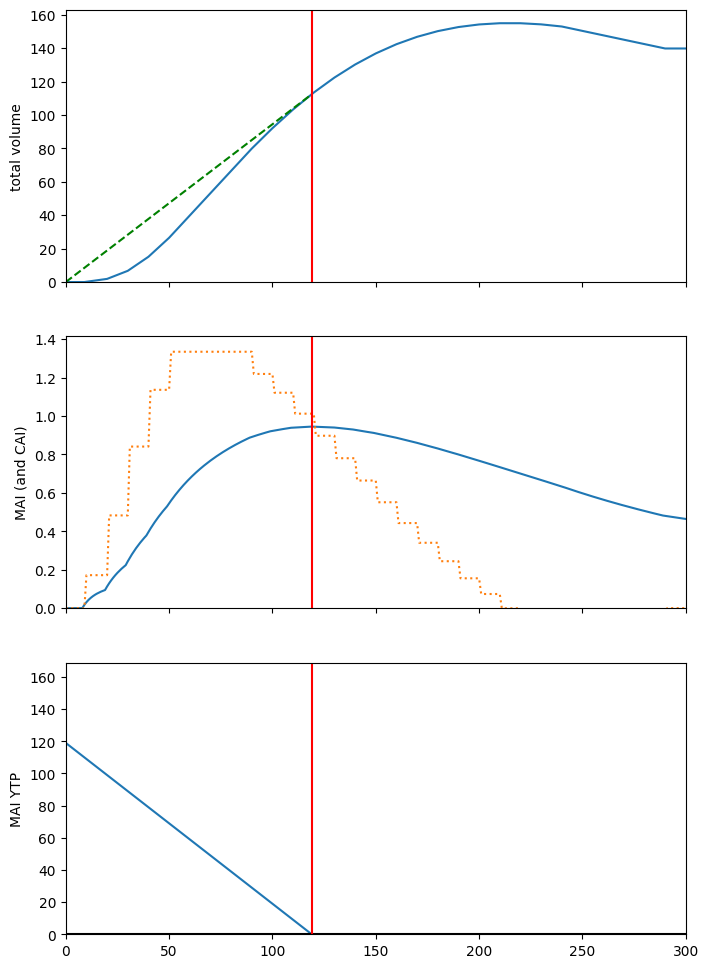

In [59]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

cvol = c
ccai = c.cai()
cmai = c.mai()
cmaiytp = c.mai().ytp()
x_cmai = cmaiytp.lookup(0) # optimal rotation age (i.e., culmination of MAI curve)
labels = 'total volume', 'MAI (and CAI)', 'MAI YTP'

ax[0].plot(*zip(*c.points()))
ax[0].plot([0, x_cmai], [0., cvol[x_cmai]], linestyle='--', color='green')

ax[1].plot(*zip(*c.mai().points()))
ax[1].plot(*zip(*c.cai().points()), linestyle=':')

ax[2].plot(*zip(*c.mai().ytp().points()))
ax[2].axhline(0, color='black')

for i in range(len(ax)):
    ax[i].set_ylabel(labels[i])
    ax[i].set_ylim(0, None)
    ax[i].axvline(x_cmai, color='red')
plt.xlim(0, 300)

## ACTIONS section

The ACTIONS section defines actions that can be applied in the model (e.g., harvesting, planting, thinning, fertilization, etc). 

In [64]:
with open(woodstock_model_files_act_path, 'w') as file:
    print('ACTIONS', file=file)
    print('*ACTION harvest Y', file=file)
    print('*OPERABLE harvest', file=file)
    print('? 1 ? ? ? ? _AGE >= 90 AND _AGE <= 600', file=file)

## TRANSITIONS section

The TRANSITIONS section defines transitions (i.e., transition to a new development type and age class induced by applying a specific action to a specific combination of development type and age class). If there were no transitions in a forest estate model, it would simply be aging (i.e., growing) the forest forward from time step 1 through to time step N.

In [65]:
with open(woodstock_model_files_trn_path, 'w') as file:
    acode = 'harvest'
    print('*CASE', acode, file=file)
    record_au = set()
    for au_id, au_row in stands_table.iterrows():
        if au_row.theme5 in record_au: continue
        if not au_row.theme1: continue
        target_curve_id = au_row.theme4  
        smask = ' '.join(('?', '?', '?', '?', '?', str(target_curve_id)))
        tmask = ' '.join(('?', '?' , '?', '?', str(target_curve_id), '?'))
        print('*SOURCE', smask, file=file)
        print('*TARGET', tmask, '100', file=file)
        record_au.add(au_row.theme5)